In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *  

C:\Users\odhra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data() 

(60000, 784)
(120000, 784)


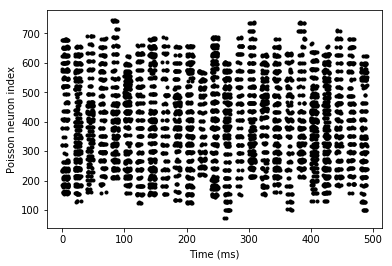

In [16]:
start_scope()

train_im = train_images.reshape(60000,784)

print(train_im.shape)

td = zeros((120000,784))

for x in range(0,60000):
    td[2*x]=train_im[x]
    

timed_data = td

print(timed_data.shape)

ta = TimedArray((timed_data)*Hz, dt=10*ms)


#the second part of the print function after the 20*ms is stating which neuron to call from. 
#the timed array is working! now convert it into poisson spikes?




Poisson_layer = PoissonGroup(784,rates = 'ta(t, i)')


spikemon_P = SpikeMonitor(Poisson_layer)


run(500*ms)

plt.plot(spikemon_P.t/ms, spikemon_P.i,'.k')
xlabel('Time (ms)')
ylabel('Poisson neuron index');